## Introduction

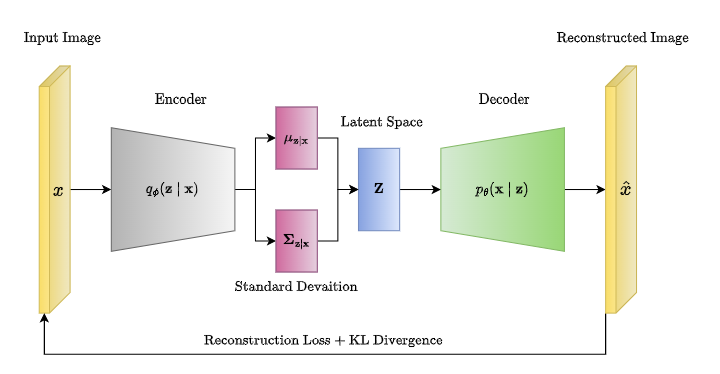

Variational Autoencoders (VAEs) are a class of generative models that have gained popularity due to their ability to learn complex data distributions in an unsupervised manner. Unlike traditional autoencoders, which compress data to a latent space and then reconstruct it, VAEs introduce a probabilistic approach to encoding and decoding. This allows them to not only reconstruct the input data but also generate new, similar data by sampling from the learned latent space.

#### **Applications of VAEs**
VAEs have a wide range of applications, particularly in the field of image generation and manipulation. They are used to generate new images that resemble a given dataset, interpolate between different images, and even perform tasks like image editing by manipulating the latent space. Other applications include anomaly detection, data compression, and generating synthetic data for training other models.

### Sampling from latent spaces of images

#### **What is Latent Space?**
In the context of VAEs, latent space refers to the compressed representation of the input data. When an image is passed through a VAE, it is encoded into a lower-dimensional latent space, where each point in this space represents a possible variation of the input data. The latent space captures the underlying structure of the data, allowing for meaningful manipulations and generation of new samples.

#### **What is Sampling?**
Sampling from the latent space involves selecting points from this space and decoding them back into the original data space, such as generating an image. Since the latent space is modeled as a probability distribution, usually a multivariate Gaussian, sampling involves drawing points from this distribution.

#### **Why is Sampling Needed?**
Sampling is essential for generating new data that is similar to the original data. Without sampling, a VAE would only reconstruct the exact input data rather than creating new variations. By sampling from the latent space, we can explore different points and generate new images, even those not present in the original dataset.

### Concept vectors for image editing

Concept vectors are directions in the latent space that correspond to specific semantic attributes of the data. For instance, in the context of facial images, a concept vector might represent "smiling" or "wearing glasses." By moving along these vectors in the latent space, we can modify the corresponding attributes of an image. This approach allows for intuitive and targeted image editing, where changes are made by simple arithmetic operations on the latent space representations.

### Variational autoencoders

The core of the VAE lies in its architecture, which consists of an encoder, a decoder, and a latent space characterized by a probability distribution.

#### **VAE Architecture**

1. **Encoder**: The encoder maps the input data $𝑥$ to a mean $𝜇$ and a standard deviation $𝜎$ of the latent space distribution. Mathematically, this can be represented as: $$z∼N(μ(x),σ(x)^2)$$ where, $z$ is a point in the latent space.

2. **Decoder**: The decoder takes the sampled latent variable $z$ and maps it back to the data space, reconstructing the input data $𝑥′$. The decoder is trained to minimize the difference between the input data $x$ and the reconstructed data $𝑥′$.

3. **Latent Space**: The latent space is modeled as a Gaussian distribution, which allows for easy sampling and interpolation. The mean $𝜇$ and variance $σ^2$ are learned by the encoder.

#### **Loss Function**

The loss function of a VAE has two components: the reconstruction loss and the KL divergence.

1. **Reconstruction Loss**: This term measures how well the decoder is able to reconstruct the input data from the latent space. It is typically measured using a metric like Mean Squared Error (MSE) or Binary Cross-Entropy (BCE) between the input $x$ and the reconstructed output $𝑥′$.

2. **KL Divergence**: The Kullback-Leibler (KL) divergence measures the difference between the learned latent space distribution and the prior distribution (usually a standard Gaussian). This term encourages the latent space to be continuous and ensures that different parts of the latent space generate meaningful data.
$$ \text{KL}(\mathcal{N}(\mu, \sigma^2) || \mathcal{N}(0, 1)) = \frac{1}{2} \sum_{i=1}^{d} \left( \sigma_i^2 + \mu_i^2 - \log(\sigma_i^2) - 1 \right) $$

#### **Reparameterization Trick**
The reparameterization trick is a technique used to make the backpropagation through the stochastic latent variable $z$ possible. Instead of sampling $z$ directly from $𝑁(𝜇,𝜎^2)$, we express $z$ as:
$$ 𝑧 = 𝜇 + 𝜎 ⋅ 𝜖 $$
where, $𝜖∼𝑁(0,1)$. This allows the gradient to flow through $μ$ and $σ$ during training, enabling the use of standard optimization techniques like gradient descent.

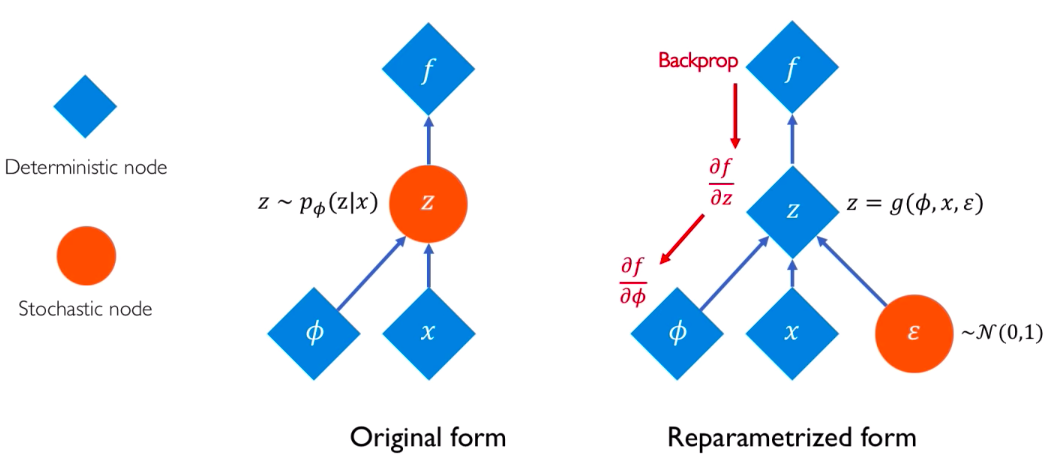

## Generating images with variational autoencoders

Once trained, a VAE can generate new images by sampling points from the latent space and passing them through the decoder. The quality and diversity of the generated images depend on how well the VAE has learned the underlying data distribution.

By sampling from different regions of the latent space, one can generate a wide variety of images, each reflecting different characteristics captured by the model. This process showcases the generative power of VAEs and their ability to create novel data from learned distributions.

## VAE encoder network

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Tuple

class Encoder(nn.Module):
    """
    A simple encoder model for our VAE.

    Args:
    - latent_dim (int): the dimension of the latent space.
    """
    def __init__(self, latent_dim: int = 2):
        super(Encoder, self).__init__()
        self.in_conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1) # padding=1 to keep the size of the image the same
        self.hidden_conv = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.fully_connected_layer_1 = nn.Linear(64*7*7, 32) # it's a good exercise to calculate the input size of this layer
        self.fully_connected_layer_2 = nn.Linear(32, 16)
        self.z_mean = nn.Linear(16, latent_dim)
        self.z_log_var = nn.Linear(16, latent_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the mean and log variance of the latent Gaussian distribution.
        (Why log variance? Numerical stability, see the paper.)
        Args:
            x (torch.Tensor): the input tensor of images [batch_size, 1, 28, 28]

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (z_mean, z_log_var), the mean and log variance of the latent Gaussian.
        """
        x = F.relu(self.in_conv(x))
        x = F.relu(self.hidden_conv(x))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fully_connected_layer_1(x))
        x = F.relu(self.fully_connected_layer_2(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)

        return z_mean, z_log_var

In [ ]:
encoder = Encoder()
for name, param in encoder.named_parameters():
    print(f"Parameter: {name} | Size: {param.size()}")

Parameter: in_conv.weight | Size: torch.Size([32, 1, 3, 3])
Parameter: in_conv.bias | Size: torch.Size([32])
Parameter: hidden_conv.weight | Size: torch.Size([64, 32, 3, 3])
Parameter: hidden_conv.bias | Size: torch.Size([64])
Parameter: fully_connected_layer_1.weight | Size: torch.Size([32, 3136])
Parameter: fully_connected_layer_1.bias | Size: torch.Size([32])
Parameter: fully_connected_layer_2.weight | Size: torch.Size([16, 32])
Parameter: fully_connected_layer_2.bias | Size: torch.Size([16])
Parameter: z_mean.weight | Size: torch.Size([2, 16])
Parameter: z_mean.bias | Size: torch.Size([2])
Parameter: z_log_var.weight | Size: torch.Size([2, 16])
Parameter: z_log_var.bias | Size: torch.Size([2])


## Latent-space-sampling layer

In [ ]:
class Sampler(nn.Module):
    def __init__(self):
        super(Sampler, self).__init__()

    def forward(self, z_mean: torch.Tensor, z_log_var: torch.Tensor) -> torch.Tensor:
        """
        Samples from the latent Gaussian distribution using the reparameterization trick.

        Args:
            z_mean (torch.Tensor): the mean of the latent Gaussian [batch_size, latent_dim]
            z_log_var (torch.Tensor): the log variance of the latent Gaussian [batch_size, latent_dim]

        Returns:
            torch.Tensor: the sampled latent vector [batch_size, latent_dim]
        """
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

## VAE decoder network, mapping latent space points to images

In [ ]:
class Decoder(nn.Module):
    """
    A simple decoder model for our VAE.

    Args:
    - latent_dim (int): the dimension of the latent space.
    """
    def __init__(self, latent_dim: int = 2):
        super(Decoder, self).__init__()
        self.fully_connected_layer = nn.Linear(latent_dim, 64*7*7)
        self.hidden_conv_1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.hidden_conv_2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.out_conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the reconstructed image.

        Args:
            x (torch.Tensor): the input tensor of latent vectors [batch_size, latent_dim]

        Returns:
            torch.Tensor: the reconstructed image [batch_size, 1, 28, 28]
        """
        x = F.relu(self.fully_connected_layer(x))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.hidden_conv_1(x))
        x = F.relu(self.hidden_conv_2(x))
        x = F.sigmoid(self.out_conv(x))

        return x

In [ ]:
decoder = Decoder()
for name, param in decoder.named_parameters():
    print(f"Parameter: {name} | Size: {param.size()}")

Parameter: fully_connected_layer.weight | Size: torch.Size([3136, 2])
Parameter: fully_connected_layer.bias | Size: torch.Size([3136])
Parameter: hidden_conv_1.weight | Size: torch.Size([64, 64, 3, 3])
Parameter: hidden_conv_1.bias | Size: torch.Size([64])
Parameter: hidden_conv_2.weight | Size: torch.Size([64, 32, 3, 3])
Parameter: hidden_conv_2.bias | Size: torch.Size([32])
Parameter: out_conv.weight | Size: torch.Size([1, 32, 3, 3])
Parameter: out_conv.bias | Size: torch.Size([1])


## VAE model

In [ ]:
class simpleVAE(nn.Module):
    def __init__(self, latent_dim: int = 2):
        super(simpleVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.sampler = Sampler()
        self.decoder = Decoder(latent_dim)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns the reconstructed image and the mean and log variance of the latent Gaussian.

        Args:
            x (torch.Tensor): the input tensor of images [batch_size, 1, 28, 28]

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: (reconstructed_x, z_mean, z_log_var)
        """
        z_mean, z_log_var = self.encoder(x)
        z = self.sampler(z_mean, z_log_var)
        reconstructed_x = self.decoder(z)

        return reconstructed_x, z_mean, z_log_var

In [ ]:
vae = simpleVAE()
for name, param in vae.named_parameters():
    print(f"Parameter: {name} | Size: {param.size()}")

print(f"Number of parameters in the model: {sum(p.numel() for p in vae.parameters())}")

Parameter: encoder.in_conv.weight | Size: torch.Size([32, 1, 3, 3])
Parameter: encoder.in_conv.bias | Size: torch.Size([32])
Parameter: encoder.hidden_conv.weight | Size: torch.Size([64, 32, 3, 3])
Parameter: encoder.hidden_conv.bias | Size: torch.Size([64])
Parameter: encoder.fully_connected_layer_1.weight | Size: torch.Size([32, 3136])
Parameter: encoder.fully_connected_layer_1.bias | Size: torch.Size([32])
Parameter: encoder.fully_connected_layer_2.weight | Size: torch.Size([16, 32])
Parameter: encoder.fully_connected_layer_2.bias | Size: torch.Size([16])
Parameter: encoder.z_mean.weight | Size: torch.Size([2, 16])
Parameter: encoder.z_mean.bias | Size: torch.Size([2])
Parameter: encoder.z_log_var.weight | Size: torch.Size([2, 16])
Parameter: encoder.z_log_var.bias | Size: torch.Size([2])
Parameter: decoder.fully_connected_layer.weight | Size: torch.Size([3136, 2])
Parameter: decoder.fully_connected_layer.bias | Size: torch.Size([3136])
Parameter: decoder.hidden_conv_1.weight | Size

In [ ]:
# test on random input
x = torch.randn(16, 1, 28, 28)
reconstructed_x, z_mean, z_log_var = vae(x)
print(f"Input size: {x.size()} | Output size: {reconstructed_x.size()} | z_mean size: {z_mean.size()} | z_log_var size: {z_log_var.size()}")

Input size: torch.Size([16, 1, 28, 28]) | Output size: torch.Size([16, 1, 28, 28]) | z_mean size: torch.Size([16, 2]) | z_log_var size: torch.Size([16, 2])


## Latent-space visualization

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
def visualize_latent_space(vae: simpleVAE, data_loader: DataLoader, labels_map: dict) -> None:
    """
    Visualizes the latent space using the encoder portion of the VAE.

    Args:
    - vae (simpleVAE): the trained VAE model
    - data_loader (DataLoader): a DataLoader wrapping the dataset you want to visualize on
    """
    vae.eval()
    for i, (x, y) in enumerate(data_loader):
        x = x.to('cuda' if torch.cuda.is_available() else 'cpu')
        z_mean, _ = vae.encoder(x)
        plt.scatter(z_mean[:, 0].cpu().detach().numpy(), z_mean[:, 1].cpu().detach().numpy(),)

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space")
    plt.colorbar()
    plt.show()

    return

## Latent-space exploration

In [ ]:
import numpy as np
def explore_latent_space(vae: simpleVAE, n: int = 10) -> None:
    xs = torch.linspace(-3, 3, n)
    ys = torch.linspace(-3, 3, n)

    fig, axs = plt.subplots(n, n, figsize=(20, 20))

    reconstructions = {}
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            z = torch.tensor([[x, y]]).to('cuda' if torch.cuda.is_available() else 'cpu')
            reconstruction = vae.decoder(z)
            reconstructions[(x.item(), y.item())] = reconstruction

            # Assuming the reconstruction is a 2D image
            axs[i, j].imshow(reconstruction.cpu().squeeze().detach().numpy(), cmap='gray')
            axs[i, j].axis('off')

    # Label the axes
    plt.xticks(np.arange(n), np.round(xs.cpu().numpy(), 2))
    plt.yticks(np.arange(n), np.round(ys.cpu().numpy(), 2))
    plt.show()

    return

## Training the VAE

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
import torch.optim as optim

# Download training data from torchvision
train_data= datasets.MNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Create data loaders
train_dataloader = DataLoader(train_data, batch_size=256)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 905999.82it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 57104.65it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 242697.43it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10031874.02it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [ ]:
class custom_loss(nn.Module):
    """
    A custom loss function for our VAE.
    """
    def __init__(self):
        super(custom_loss, self).__init__()

    def forward(self, x_recon, x, mu, logvar):
        """
        Returns the reconstruction loss, the KL divergence loss, and the total loss.

        args:
            x_recon (torch.Tensor): the reconstructed image [batch_size, 28, 28, 1]
            x (torch.Tensor): the original image [batch_size, 28, 28, 1]
            mu (torch.Tensor): the mean of the latent Gaussian [batch_size, latent_dim]
            logvar (torch.Tensor): the log variance of the latent Gaussian [batch_size, latent_dim]

        returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: (recon_loss, kldivergence, total_loss)
        """
        # Reconstruction loss
        recon_loss = nn.BCELoss(reduction='sum')(x_recon, x)/x.size(0)
        # KL divergence loss
        kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        return recon_loss, kldivergence, recon_loss + kldivergence

In [ ]:
from tqdm import tqdm
from typing import List, Tuple

# Define the training loop function
def vae_trainer(model: nn.Module, train_dataloader: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module) -> Tuple[List[float], List[float], List[float]]:
    # Store losses in these lists
    total_loss_list = []
    recon_loss_list = []
    kl_loss_list = []

    for epoch in range(epochs):
        # These lists store batch-wise losses
        epoch_recon_loss = []
        epoch_kl_loss = []
        epoch_total_loss = []

        for batch, (x, _) in (pbar := tqdm(enumerate(train_dataloader))): # We use tqdm for better visualization
            x = x.to('cuda' if torch.cuda.is_available() else 'cpu') # transfer to cuda if available

            optimizer.zero_grad() # clear grads
            out, mu, log_var = model(x) # forward pass
            recon_loss, kl_div, total_loss = loss_fn(out, x, mu, log_var) # compute losses
            total_loss.backward() # backward pass
            optimizer.step() # weight update

            epoch_recon_loss.append(recon_loss.item())
            epoch_kl_loss.append(kl_div.item())
            epoch_total_loss.append(total_loss.item())
            pbar.set_description(f"Loss: {total_loss.item()}")

        recon_loss_list.append(np.mean(epoch_recon_loss))
        kl_loss_list.append(np.mean(epoch_kl_loss))
        total_loss_list.append(np.mean(epoch_total_loss))
        print(f"Epoch {epoch + 1} Loss: {np.mean(epoch_total_loss)}")

    print("Training Complete")
    print(f"Final Loss: {np.mean(total_loss_list)}")

    return total_loss_list, recon_loss_list, kl_loss_list


In [ ]:
loss_fn = custom_loss()
optimizer = optim.Adam(vae.parameters())
vae = vae.to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
total_loss_list, recon_loss_list, kl_loss_list = vae_trainer(vae, train_dataloader, 10, optimizer, loss_fn)

Loss: 209.06544494628906: : 235it [00:17, 13.57it/s]


Epoch 1 Loss: 245.76672415226065


Loss: 207.4243927001953: : 235it [00:12, 19.46it/s]


Epoch 2 Loss: 207.83439246644366


Loss: 206.9738006591797: : 235it [00:10, 21.61it/s]


Epoch 3 Loss: 207.1315441375083


Loss: 206.5265655517578: : 235it [00:11, 21.26it/s]


Epoch 4 Loss: 206.79973053627825


Loss: 206.28909301757812: : 235it [00:11, 21.05it/s]


Epoch 5 Loss: 206.67125653206034


Loss: 197.142822265625: : 235it [00:11, 20.88it/s]


Epoch 6 Loss: 199.93672907403175


Loss: 175.6546173095703: : 235it [00:11, 20.92it/s]


Epoch 7 Loss: 181.06857221887466


Loss: 167.58700561523438: : 235it [00:11, 20.92it/s]


Epoch 8 Loss: 168.02006582706534


Loss: 163.43051147460938: : 235it [00:11, 20.98it/s]


Epoch 9 Loss: 164.75354938912898


Loss: 161.1815948486328: : 235it [00:12, 19.20it/s]

Epoch 10 Loss: 162.64783558946974
Training Complete
Final Loss: 195.06303999231216


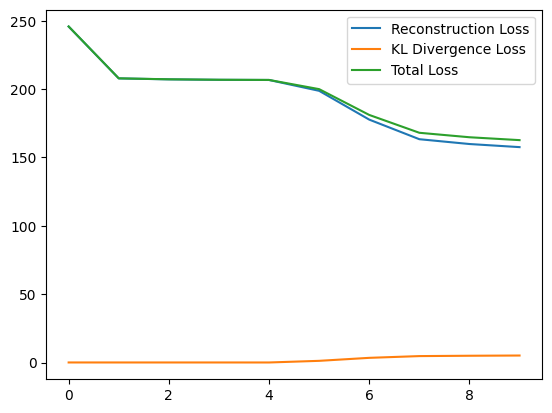

In [ ]:
import matplotlib.pyplot as plt

def get_loss_curves(recon_loss_list, kl_loss_list, total_loss_list):
    plt.plot(recon_loss_list, label='Reconstruction Loss')
    plt.plot(kl_loss_list, label='KL Divergence Loss')
    plt.plot(total_loss_list, label='Total Loss')
    plt.legend()
    plt.show()

get_loss_curves(recon_loss_list, kl_loss_list, total_loss_list)

In [ ]:
from torch.utils.data import Subset

subet_data = Subset(train_data, range(1000))
subet_dataloader = DataLoader(subet_data, batch_size=1)

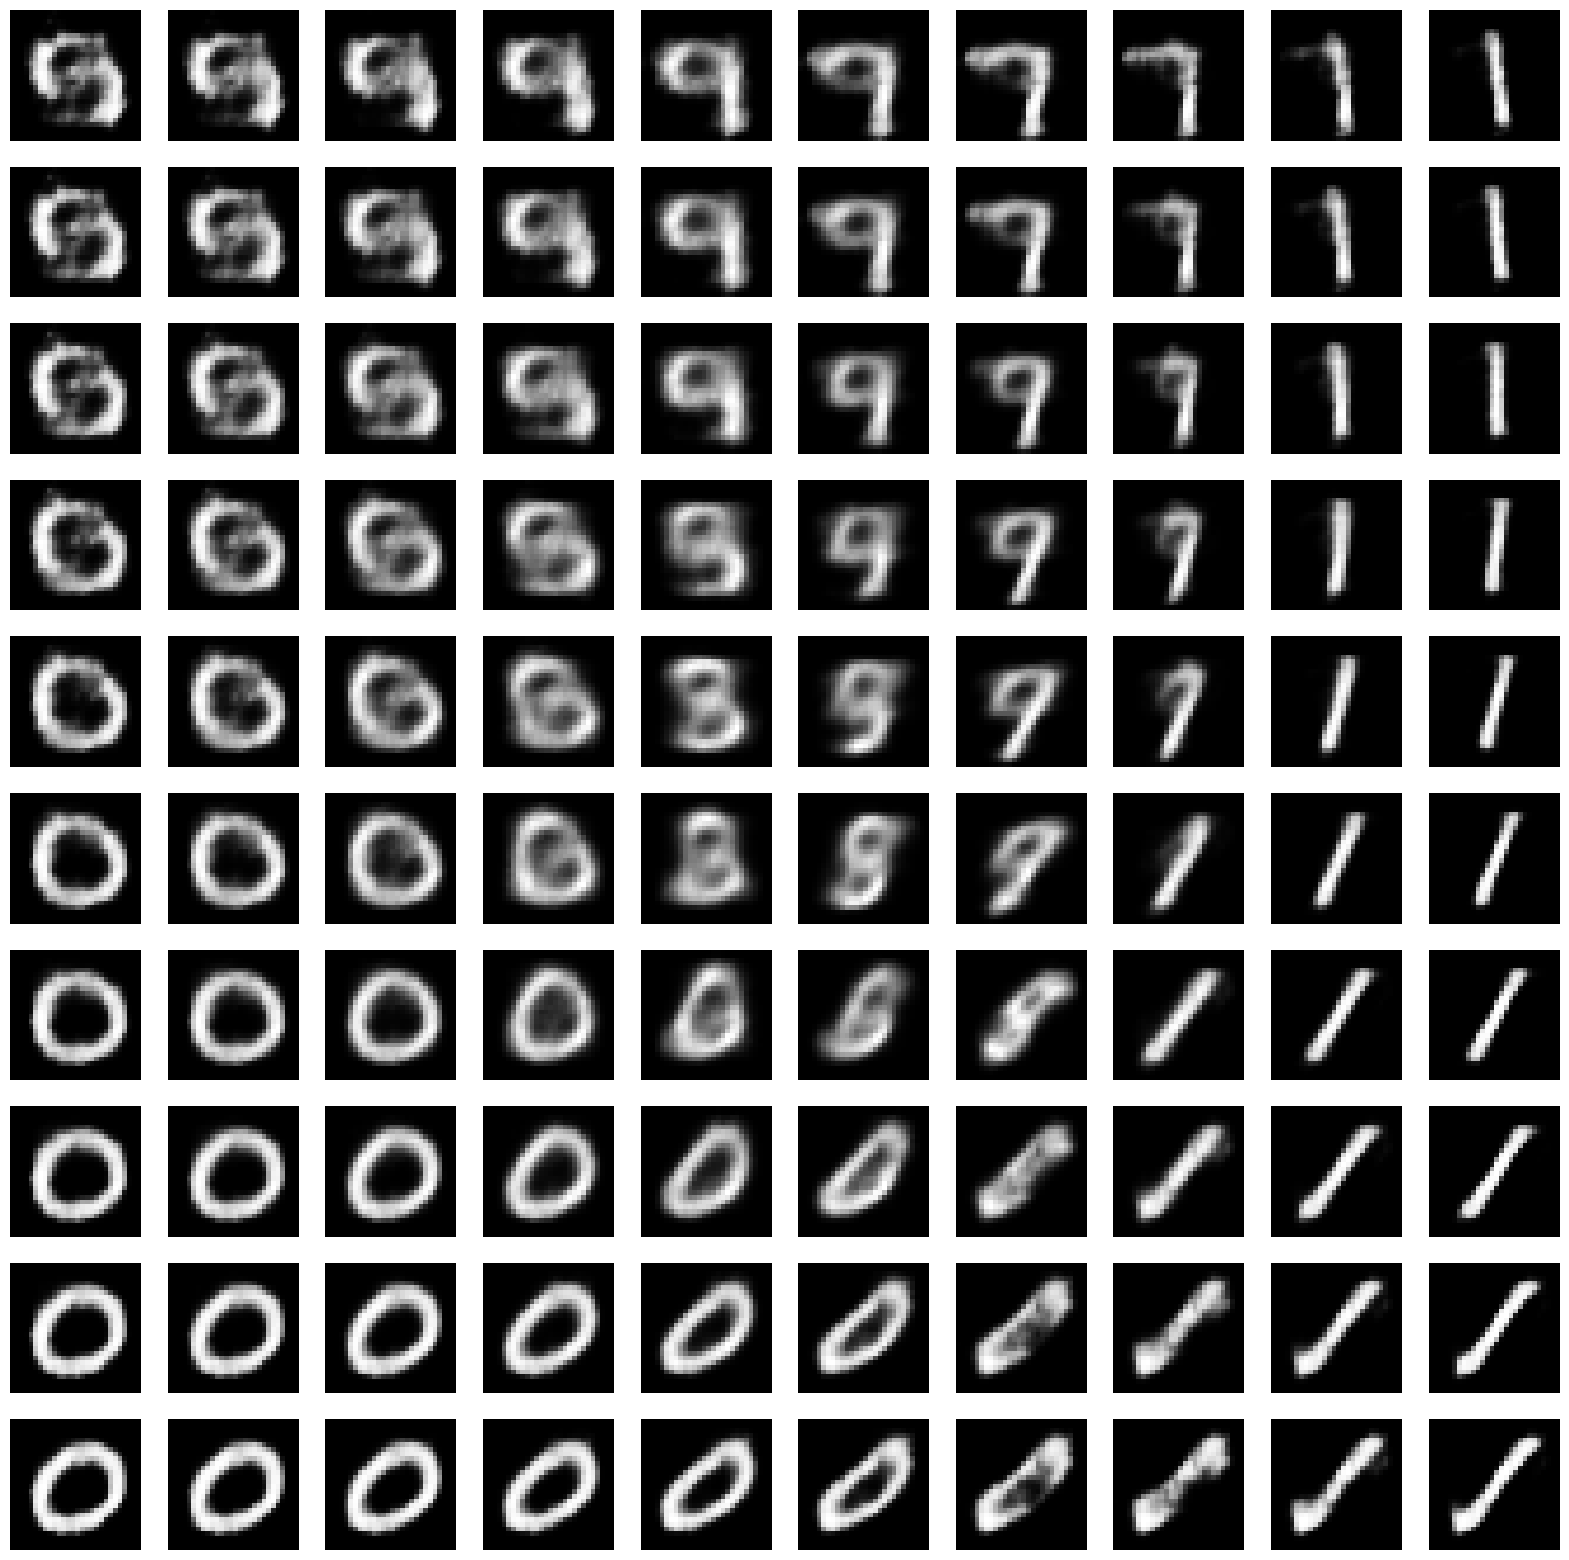

In [ ]:
explore_latent_space(vae, n = 10)